# Carol Zhang

## Research Question/Interests

### Guest Experience & Satisfaction

Guest experience and satisfaction are crucial for Airbnb hosts since positive reviews can increase booking rates and listing visibility. Many travellers incorporate other guest reviews into their decision-making process when evaluating accommodation options. This research will explore key factors influencing guest satisfaction, such as pricing, host responsiveness, and amenities. By identifying patterns in high-rated listings, hosts can refine their offerings to improve guest experience and secure better reviews. 

### Key Research Questions
- Q1. How do listing features like the number of amenities or instant booking availability impact guest satisfaction ratings? 
- Q2. What is the relationship between the different ratings and the price of listings for different property types?
- Q3. Which amenities are most frequently associated with higher guest ratings in Airbnb listings?

## EDA

### Imports

In [1]:
import os
import ast
import altair as alt
import pandas as pd
from toolz.curried import pipe
import numpy as np
import sys

# # Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# # Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

sys.path.append(os.path.abspath("../../code"))
from cleaning_workflows import prepare_dataset

### Loading in the data

In [2]:
df = pd.read_csv('../../data/raw/listings.csv', parse_dates=['first_review', 'last_review'])

df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,39572,https://www.airbnb.com/rooms/39572,20250103033441,2025-01-03,city scrape,1 br in a 2 br apt (Midtown West),NaN,NaN,https://a0.muscache.com/pictures/fd1bffd9-ccf8...,169927,...,5.00,4.98,4.86,NaN,f,2,1,1,0,0.25
1,39593,https://www.airbnb.com/rooms/39593,20250103033441,2025-01-03,city scrape,A lovely room w/ a Manhattan view,"A private, furnished large room to rent Jan/F...","Nate Silver called this super safe, clean, qui...",https://a0.muscache.com/pictures/0b9110f7-3b24...,110506,...,4.96,4.79,4.93,NaN,f,1,0,1,0,0.20
2,39704,https://www.airbnb.com/rooms/39704,20250103033441,2025-01-03,previous scrape,"Private, Large & Sunny 1BR w/W&D",It's a No Brainer:<br />•Terrific Space For Le...,The Neighborhood<br />• Rich History <br />• B...,https://a0.muscache.com/pictures/0bc4e8a4-c047...,170510,...,4.92,4.38,4.72,NaN,f,2,2,0,0,1.93
3,42300,https://www.airbnb.com/rooms/42300,20250103033441,2025-01-03,city scrape,Beautiful Lower East Side Loft,Architect-owned loft is a corner unit in a bea...,"The apartment is in the border of Soho, LES an...",https://a0.muscache.com/pictures/0e285e13-ee14...,184755,...,4.87,4.57,4.62,NaN,f,1,1,0,0,0.40
4,42729,https://www.airbnb.com/rooms/42729,20250103033441,2025-01-03,city scrape,@HouseOnHenrySt - Private 2nd bedroom w/shared...,NaN,"Lovely old Brooklyn neighborhood, with brick/b...",https://a0.muscache.com/pictures/925fe213-f5e1...,11481,...,4.73,4.58,4.64,NaN,f,4,1,3,0,1.26


In [3]:
df_cleaned = prepare_dataset(df)
df_cleaned.head()

,name,description,neighborhood_overview,host_id,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1 br in a 2 br apt (Midtown West),No description available,No overview available,169927,2010-07-17,"Saint-Aubin-sur-Scie, France","Facebook Likes:\r\nNew York French Geek, David...",within a day,1.00,0.88,...,4.98,5.00,4.98,4.86,False,2,1,1,0,0.25
1,A lovely room w/ a Manhattan view,"A private, furnished large room to rent Jan/F...","Nate Silver called this super safe, clean, qui...",110506,2010-04-18,"New York, NY","I grew up in South Korea, moved to Montreal, C...",within a few hours,1.00,0.60,...,4.96,4.96,4.79,4.93,False,1,0,1,0,0.20
2,"Private, Large & Sunny 1BR w/W&D",It's a No Brainer:<br />•Terrific Space For Le...,The Neighborhood<br />• Rich History <br />• B...,170510,2010-07-18,"New York, United States",I am a self employed licensed real estate brok...,No response time,1.00,0.88,...,4.89,4.92,4.38,4.72,False,2,2,0,0,1.93
3,Beautiful Lower East Side Loft,Architect-owned loft is a corner unit in a bea...,"The apartment is in the border of Soho, LES an...",184755,2010-07-29,"New York, NY",I am an architect living in NYC and have my ow...,within a day,1.00,1.00,...,4.85,4.87,4.57,4.62,False,1,1,0,0,0.40
4,@HouseOnHenrySt - Private 2nd bedroom w/shared...,No description available,"Lovely old Brooklyn neighborhood, with brick/b...",11481,2009-03-26,"New York, NY",I have been a host with Airbnb since its intro...,within a day,0.67,0.33,...,4.71,4.73,4.58,4.64,False,4,1,3,0,1.26


#### Summary Statistics 

In [4]:
df_cleaned.shape

(37784, 57)

In [5]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37784 entries, 0 to 37783
Data columns (total 57 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   name                                          37784 non-null  object        
 1   description                                   37784 non-null  object        
 2   neighborhood_overview                         37784 non-null  object        
 3   host_id                                       37784 non-null  int64         
 4   host_since                                    37784 non-null  datetime64[ns]
 5   host_location                                 37784 non-null  object        
 6   host_about                                    37784 non-null  object        
 7   host_response_time                            37784 non-null  object        
 8   host_response_rate                            37784 non-null  floa

In [6]:
df_cleaned.isnull().sum()

name                                            0
description                                     0
neighborhood_overview                           0
host_id                                         0
host_since                                      0
host_location                                   0
host_about                                      0
host_response_time                              0
host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_neighbourhood                              0
host_listings_count                             0
host_total_listings_count                       0
host_verifications                              0
host_has_profile_pic                            0
host_identity_verified                          0
neighbourhood_cleansed                          0
neighbourhood_group_cleansed                    0
latitude                                        0


**Comments** 
- There are 377,784 observations and 56 columns after cleaning 
- There are no missing values in the dataset after imputation 

#### Feature Engineering

**`amenities`**

Currently, amenities are stored as a list of strings. To make this variable more useful, I want to apply the following transformations: 
1. **Convert the list of amenities into separate binary columns**, where each column represents whether a specific amenity is included in a listing (1 for yes, 0 for no). This will help answer Q3 by identifying which amenities are the most common and their correlation with higher-rated listings. 
2. **Create a new column counting the number of amenities** for each listing based on the number of elements in the `amenities` list. This numerical value will be used to answer Q1 to help us explore whether listings with more amenities receive higher ratings. 

In [7]:
# Display the amenities column
print(df_cleaned['amenities'])

0        ["Hangers", "Wifi", "Smoke alarm", "Carbon mon...
1        ["Hangers", "Smoke alarm", "Hair dryer", "Clot...
2        ["Hangers", "Coffee maker", "Smoke alarm", "Fi...
3        ["Hangers", "Coffee maker", "Smoke alarm", "Ha...
4        ["Hangers", "Coffee maker", "Smoke alarm", "TV...
                               ...                        
37779    ["Hangers", "Smoke alarm", "Fire extinguisher"...
37780    ["Dedicated workspace", "HDTV with Amazon Prim...
37781    ["Hangers", "Smoke alarm", "Stove", "Cooking b...
37782    ["Wifi", "Central air conditioning", "Hot wate...
37783    ["Wifi", "TV", "Dedicated workspace", "Carbon ...
Name: amenities, Length: 37784, dtype: object


In [8]:
# Transformation 1: Convert the list of amenities into separate binary columns
# Convert the string representation of lists back into actual lists
df_amenities = df_cleaned['amenities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Calculate the frequency of each amenity
amenity_counts = df_amenities.explode().value_counts()

# Select the top 25 amenities by frequency
top_25_amenities = amenity_counts.head(25).index.tolist()

# Concatenate the new amenity columns to df_cleaned
amenity_columns = pd.DataFrame(
    [[1 if amenity in x else 0 for amenity in top_25_amenities] for x in df_cleaned['amenities']],
    columns=top_25_amenities)

df_cleaned = pd.concat([df_cleaned, amenity_columns], axis=1)

In [9]:
# Transformation 2: Create a new column counting the number of amenities in each listing 
df_cleaned['num_amenities'] = df_cleaned['amenities'].apply(len)
print(df_cleaned[['amenities', 'num_amenities']].head())

                                           amenities  num_amenities
0  ["Hangers", "Wifi", "Smoke alarm", "Carbon mon...            192
1  ["Hangers", "Smoke alarm", "Hair dryer", "Clot...            687
2  ["Hangers", "Coffee maker", "Smoke alarm", "Fi...            454
3  ["Hangers", "Coffee maker", "Smoke alarm", "Ha...            442
4  ["Hangers", "Coffee maker", "Smoke alarm", "TV...            462


**`name`, `description`, `neighborhood_overview`**

To quantify the descriptiveness of a listing and make these variables more useful, I will **create new columns to count the number of words in the string values**. This can serve as a proxy for the number of details that are included in the listing. For example, a property with the name "2 Bedroom Apartment" (word count = 3) is less descriptive than "Sunny, beautiful 2 Bedroom Apartment in Downtown Manhatten" (word count = 8). 

In [10]:
# Function to count the number of words in a string
def word_count(text):
    if isinstance(text, str):
        return len(text.split())
    return 0  # If the text is not a string, return 0

df_cleaned['name_word_count'] = df_cleaned['name'].apply(word_count)
df_cleaned['description_word_count'] = df_cleaned['description'].apply(word_count)
df_cleaned['neighborhood_overview_word_count'] = df_cleaned['neighborhood_overview'].apply(word_count)

print(df_cleaned[['name_word_count', 'description_word_count', 'neighborhood_overview_word_count']].head())

   name_word_count  description_word_count  neighborhood_overview_word_count
0                9                       3                                 3
1                7                      58                               153
2                6                      32                                68
3                5                      88                                21
4                7                       3                                16


#### Univariate Analysis

In [11]:
# Describe quantitative columns, excluding binary columns for amenities and other unmeaningful columns
exclude_columns = top_25_amenities + ['latitude', 'longitude', 'host_id']
df_numerical = df_cleaned.drop(columns=exclude_columns)

pd.set_option('display.max_columns', None)
df_numerical.describe()

,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,num_amenities,name_word_count,description_word_count,neighborhood_overview_word_count
count,37784,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,3.778400e+04,37784.000000,3.778400e+04,37784.000000,37784.000000,37784.000000,37784.000000,37784,37784.000000,37784.000000,37784.000000,37784,37784,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000,37784.000000
mean,2017-03-06 09:48:26.373067776,0.952508,0.812859,263.054864,351.429229,2.754896,1.119654,1.321723,1.383946,170.434126,28.882172,5.793950e+04,29.497840,8.501277e+05,12.314075,27.011275,42.416552,163.400963,2025-01-03 00:00:00,25.658639,3.731447,0.294357,2021-02-19 02:42:05.259369216,2023-05-11 06:14:56.379419904,4.763849,4.805924,4.704505,4.870094,4.867555,4.775639,4.676217,71.636354,45.435555,23.985232,0.005187,0.685365,445.982638,6.148052,57.270035,36.569289
min,2008-08-11 00:00:00,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,8.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,2025-01-03 00:00:00,0.000000,0.000000,0.000000,2009-05-25 00:00:00,2011-05-12 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000,2.000000,1.000000,1.000000,1.000000
25%,2014-07-07 00:00:00,1.000000,0.840000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,113.750000,30.000000,1.500000e+02,30.000000,3.650000e+02,0.000000,0.000000,0.000000,0.000000,2025-01-03 00:00:00,0.000000,0.000000,0.000000,2019-01-21 00:00:00,2023-03-19 00:00:00,4.750000,4.817500,4.690000,4.890000,4.900000,4.750000,4.670000,1.000000,0.000000,0.000000,0.000000,0.160000,191.000000,5.000000,39.000000,3.000000
50%,2016-08-02 00:00:00,1.000000,0.880000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,132.000000,30.000000,3.650000e+02,30.000000,5.676500e+02,2.000000,23.000000,41.000000,155.000000,2025-01-03 00:00:00,3.000000,0.000000,0.000000,2022-12-11 00:00:00,2024-10-11 00:00:00,4.850000,4.900000,4.810000,4.950000,4.960000,4.850000,4.760000,2.000000,1.000000,1.000000,0.000000,0.290000,385.000000,6.000000,62.000000,10.000000
75%,2019-10-29 00:00:00,1.000000,0.950000,10.000000,15.000000,4.000000,1.000000,1.000000,1.000000,156.000000,30.000000,1.125000e+03,30.000000,1.125000e+03,29.000000,58.000000,88.000000,329.000000,2025-01-03 00:00:00,22.000000,1.000000,0.000000,2023-01-01 00:00:00,2024-12-15 00:00:00,4.940000,4.970000,4.910000,5.000000,5.000000,4.950000,4.850000,9.000000,2.000000,2.000000,0.000000,0.550000,635.000000,8.000000,79.000000,60.000000
max,2024-12-27 00:00:00,1.000000,1.000000,5079.000000,9048.000000,16.000000,15.500000,16.000000,42.000000,20000.000000,1250.000000,2.147484e+09,1250.000000,2.147484e+09,30.000000,60.000000,90.000000,365.000000,2025-01-03 00:00:00,2485.000000,1779.000000,137.000000,2025-01-02 00:00:00,2025-01-02 00:00:00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1154.000000,1154.000000,739.000000,4.000000,116.300000,2134.000000,47.000000,185.000000,227.000000
std,NaN,0.173547,0.232501,1000.361076,1196.81

In [12]:
# Nominal Features
df_cleaned.describe(include=['object'])

,name,description,neighborhood_overview,host_location,host_about,host_response_time,host_neighbourhood,host_verifications,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,amenities
count,37784,37784,37784,37784,37784,37784,37784,37784,37784,37784,37784,37784,37784
unique,36058,31140,15117,988,11654,5,521,7,223,5,69,4,30453
top,Water View King Bed Hotel Room,No description available,No overview available,"New York, NY","We’re Blueground, a global proptech company wi...",No response time,Bedford-Stuyvesant,"['email', 'phone']",Bedford-Stuyvesant,Manhattan,Entire rental unit,Entire home/apt,"[""Wifi"", ""TV"", ""Smoke alarm"", ""Carbon monoxide..."
freq,30,973,17177,22469,17326,15585,9498,29303,2678,16819,15887,20160,237


**Comments** 
- Review scores are generally high, with an average score of around 4.8 for each category
- The average number of amenities listed per property is 25.99
- Availability is relatively high for most properties, with an average availability of 163 days in a year
- The mean price is $170.43, with a large range from 8 to 20,000 which indicates that there are both budget and luxury properties listed
- The average number of reviews is 25.66, with outliers having as many as 2485 reviews

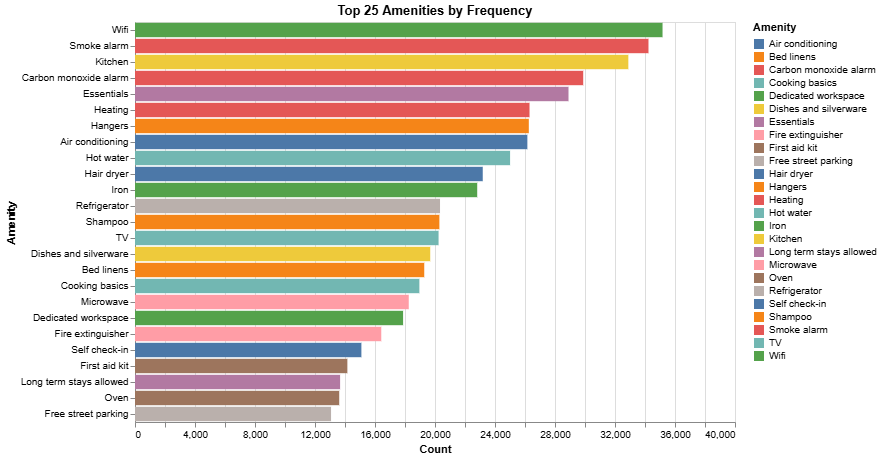

In [13]:
# Bar chart for top 25 amenities by frequency 
top_25_amenities_df = amenity_counts.head(25).reset_index()
top_25_amenities_df.columns = ['Amenity', 'Count']

top_amenities_bar = alt.Chart(top_25_amenities_df).mark_bar().encode(
    alt.X('Count:Q'),
    alt.Y('Amenity:N', sort='-x'),
    alt.Color('Amenity:N')
).properties(
    title='Top 25 Amenities by Frequency',
    width=600,
    height=400
)

top_amenities_bar

#### Multivariate Analysis

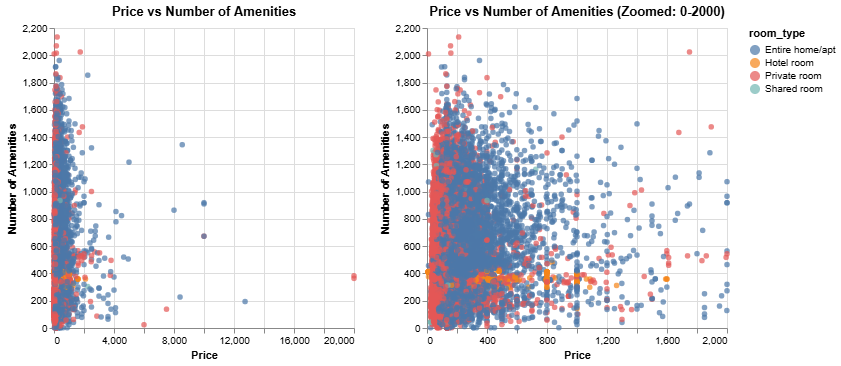

In [14]:
# Scatter plot: Price vs Number of Amenities by Room Type
price_amenities_scatter = alt.Chart(df_cleaned).mark_circle().encode(
    alt.X('price:Q', title='Price'),
    alt.Y('num_amenities:Q', title='Number of Amenities'),
    alt.Color('room_type:N'),
    tooltip=['price:Q', 'num_amenities:Q','room_type:N']
).properties(
    title='Price vs Number of Amenities'
)

# Zoom in on the left side of the graph to avoid outliers
df_filtered = df_cleaned[df_cleaned['price'] <= 2000]
scatter_zoomed = alt.Chart(df_filtered).mark_circle().encode(
    alt.X('price:Q', title='Price', scale=alt.Scale(domain=[0, 2000])),
    alt.Y('num_amenities:Q', title='Number of Amenities'),
    alt.Color('room_type:N'),
    tooltip=['price:Q', 'num_amenities:Q', 'room_type:N']
).properties(
    title='Price vs Number of Amenities (Zoomed: 0-2000)'
)

price_amenities_scatter | scatter_zoomed

The scatter plots illustrate a slightly negative relationship between price and the number of amenities in accommodations. The majority of listings cluster on the lower end of the price range, and the zoomed-in view of prices up to $2,000 highlights significant variability in the number of amenities. There is some differentiation among room types. For instance, private rooms exhibit more variability in amenities at the same price range, whereas hotel rooms tend to have a consistent number of amenities (around 400) despite varying prices.

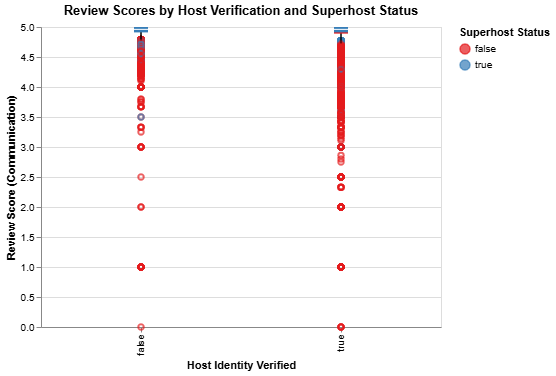

In [15]:
# Box plot: Review Score (Communication) by Host Verification and Superhost Status 
boxplot_host_communication = alt.Chart(df_cleaned).mark_boxplot().encode(
    alt.X('host_identity_verified:N', title='Host Identity Verified'),
    alt.Y('review_scores_communication:Q', title='Review Score (Communication)'),
    alt.Color('host_is_superhost:N', title='Superhost Status', scale=alt.Scale(scheme='set1')),
    tooltip=['host_identity_verified:N', 'host_is_superhost:N', 'review_scores_communication:Q']
).properties(
    title='Review Scores by Host Verification and Superhost Status',
    height=300,
    width=400
)

boxplot_host_communication

For both verified and unverified hosts, their communication review scores are high, as shown by the boxes near the top of the graph. Among the outliers with lower ratings shown by the circles, the majority of them do not have Superhost status (circles are red). This could indicate that Superhosts tend to have more standard and higher communication review scores.  

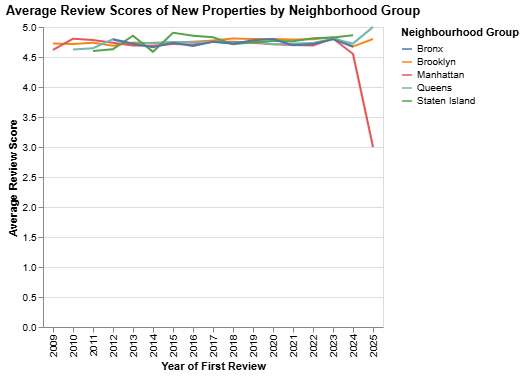

In [16]:
# Line chart: Average Rating of New Properties by Neighbourhood Group
df_cleaned['review_year'] = df_cleaned['first_review'].dt.year
line_data = df_cleaned.groupby(['review_year', 'neighbourhood_group_cleansed'])['review_scores_rating'].mean().reset_index()

line_chart = alt.Chart(line_data).mark_line().encode(
    alt.X('review_year:O', title='Year of First Review'),
    alt.Y('review_scores_rating:Q', title='Average Review Score'),
    alt.Color('neighbourhood_group_cleansed:N', title='Neighbourhood Group'),
    tooltip=['review_year:O', 'neighbourhood_group_cleansed:N', 'review_scores_rating:Q']
).properties(
    title='Average Review Scores of New Properties by Neighborhood Group'
)

line_chart

This line chart shows the average review scores for properties based on the year they were first reviewed, using the year as a proxy for how new the property is. This allows us to observe how ratings have evolved for new listings in different neighbourhoods. The chart helps identify regional patterns in guest satisfaction.

As shown by the position of the lines near the top of the graph, most review scores are very high. Most neighbourhoods have seen stable average review scores for new properties over time. However, Staten Island and Manhattan exhibit more volatility. In particular, Manhattan has experienced a sharp decline in average ratings over the last three years, indicating that newly-listed properties in this neighbourhood are receiving lower ratings from guests compared to previous years.

### Task Analysis

#### How do listing features like the number of amenities or instant booking availability impact guest satisfaction ratings?
- **Compute Derived Value**: Count/calculate the number of amenities for each listing.
- **Retrieve Value**: Extract guest satisfaction ratings, number of amenities, instant booking availability, and other variables.
- **Characterize Distribution**: Visualize the distribution of guest satisfaction ratings for listings with and without instant booking availability or other nominal variables.
- **Correlate**: Analyze the relationship between review score ratings and various variables.
- **Sort**: Sort listings based on the number of amenities to see if higher amenity counts correlate with higher satisfaction scores.

#### What is the relationship between the different ratings and the price of listings for different room types?
- **Retrieve Value**: Extract price data, various review scores, and room type.
- **Sort**: Sort the listings by price to see how prices vary across different room types.
- **Correlate**: Analyze the correlation between price and review scores for different room types (e.g., private room, entire home).
- **Filter**: Filter the dataset by room type and analyze the relationship between price and ratings within each room type.
- **Characterize Distribution**: Visualize how ratings are distributed across different price ranges and room types.
- **Determine Range**: Identify the range of prices and ratings for each room type to see the variability in guest satisfaction across price levels.
  
#### Which amenities are most frequently associated with higher guest ratings in Airbnb listings?
- **Retrieve Value**: Extract guest satisfaction ratings and the list of amenities for each property.
- **Filter**: Filter the dataset to include only listings with a high review score (e.g. above 4.5).
- **Cluster**: Group listings by the types of amenities offered and analyze the ratings within each group.
- **Find Extremum**: Identify the amenities with the highest frequency counts. 
- **Sort**: Sort the amenities by the frequency of their occurrence in top-rated listings to see which amenities are most commonly associated with high ratings.
- **Correlate**: Analyze the relationship between the presence of specific amenities and guest ratings, looking for patterns of higher ratings associated with certain amenities.

### Preliminary Sketches

#### How do listing features like the number of amenities or instant booking availability impact guest satisfaction ratings?
**Low-Fidelity Sketches** 
1. The heatmap shows which features correlate with higher guest satisfaction by using a colour gradient. This is useful for spotting trends quickly, as darker or more intense colours indicate stronger correlations. However, it aggregates data into bins, which can lead to a loss of detail about individual listings. If too many features are included, the heatmap can also be cluttered and difficult to interpret. 

2. The scatter plot shows how a single feature impacts guest satisfaction, while also adding a second feature through colour encoding. It is useful for detecting outliers and identifying trends. However, scatter plots can be overwhelming if there are too many data points, leading to overplotting. Additionally, it does not provide a holistic view of multiple features at once, as it only examines the relationship between two at a time. 

3. The boxplot is useful for visualizing the distribution of guest satisfaction ratings for different features. However, one of its main disadvantages is that it does not capture correlations between multiple features simultaneously. Additionally, the boxplot may be misleading if sample sizes for different features vary significantly.

**Final Choice** 

The heatmap was chosen as the final visualization because it effectively conveys the relationship between multiple features and guest satisfaction ratings intuitively. By structuring the data in a grid format and using a colour gradient, users can recognize trends and patterns easily. High-impact features are easily distinguishable due to the contrast in colour saturation, drawing attention to the most relevant insights in the dataset. 

#### What is the relationship between the different ratings and the price of listings for different room types?

**Low-Fidelity Sketches** 
1. The scatter plot is useful for identifying trends and outliers, such as whether higher-rated listings tend to be more expensive or if certain room types consistently receive better ratings. An interactive tool also allows users to explore different rating categories such as accuracy, communication, and value. However, a risk is potential overplotting, which may obscure patterns. 

2. The bar chart segments the ratings into ranges allowing for easy identification of price trends within each room type. However, this can also miss finer details, such as small differences in price between similar ratings. Additionally, the visual can become cluttered if too many room types or rating categories are included, making it harder to interpret the data.

3. The heatmap allows for quick identification of trends, with darker colours indicating higher prices. However, it may become difficult to interpret if there are too many rating categories or room types, leading to visual clutter. Additionally, the heatmap does not capture the underlying distribution of prices within each category. 

**Final Choice** 

The scatter plot is the best choice because it is an effective visualization for two continuous variables (price and ratings). The colour distinction for room types helps differentiate categories without overwhelming the viewer, allowing for quick comparisons. Additionally, the interactivity (e.g., dropdown for different rating categories) enhances user control, allowing them to customize the analysis and dive deeper into specific details when needed.

#### Which amenities are most frequently associated with higher guest ratings in Airbnb listings?

**Low-Fidelity Sketches** 
1. The bar chart displays the correlation between amenities and guest ratings, allowing for quick identification of which ones have the strongest positive or negative impact. By sorting the bars from highest to lowest correlation, it makes comparisons straightforward. However, it does not show the frequency, meaning an amenity with a high correlation but very few listings might be misleading. If there are many amenities, the chart could also become cluttered. 

2. The scatterplot displays the relationship between an amenity’s correlation with guest ratings and its frequency across listings. This allows for insights into whether commonly offered amenities tend to have stronger or weaker correlations with guest satisfaction. However, if many amenities cluster around similar correlation values, overplotting can occur and make it difficult to differentiate individual points. 

3. The Cleveland dot plot plots amenities along the y-axis and correlation values along the x-axis, which allows for an easy comparison of how different amenities influence guest satisfaction. Since the dots are aligned to a common scale, this makes it simple to identify the most and least impactful amenities at a glance. However, this visualization lacks a visual encoding of frequency, which could provide additional context. 

**Final Choice** 

The Cleveland dot plot aligns well with effective visualization principles by minimizing clutter, ensuring readability, and allowing for precise comparisons of correlations using positioning along a common scale. Compared to the scatterplot, it presents correlation values more intuitively without the risk of overplotting. However, since it lacks frequency encoding, a possible enhancement would be size encoding for frequency or an interactive tooltip to display additional context. This would preserve clarity while adding depth to the analysis.

## PM3 Visualizations 

### How do listing features like the number of amenities or instant booking availability impact guest satisfaction ratings?

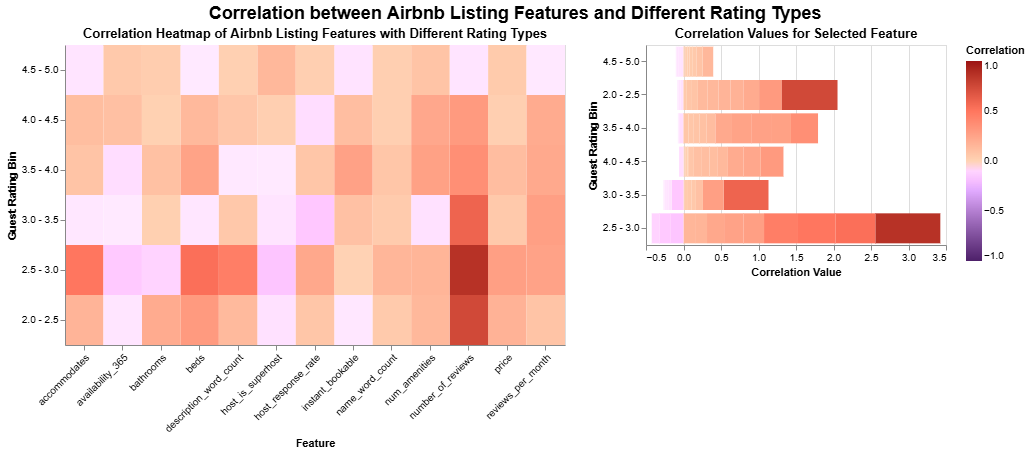

In [17]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy")

# Function to bin ratings 
def bin_ratings(rating):
    if rating == 5.0:
        return "5.0"
    elif rating >= 4.5:
        return "4.5 - 5.0"
    elif rating >= 4.0:
        return "4.0 - 4.5"
    elif rating >= 3.5:
        return "3.5 - 4.0"
    elif rating >= 3.0:
        return "3.0 - 3.5"
    elif rating >= 2.5:
        return "2.5 - 3.0"
    elif rating >= 2.0:
        return "2.0 - 2.5"
    elif rating >= 1.5:
        return "1.5 - 2.0"
    elif rating >= 1.0:
        return "1.0 - 1.5"
    elif rating >= 0.5:
        return "0.5 - 1.0"
    else:
        return "0.0 - 0.5"

# Features to analyze
features = ["price", "accommodates", "beds", "bathrooms", "instant_bookable", "host_is_superhost", 
            "host_response_rate", "number_of_reviews", "reviews_per_month", 
            "availability_365", "num_amenities", "name_word_count", "description_word_count"]

# Ratings columns for dropdown
rating_columns = [
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value"]

# Find correlations for each bin and rating type
correlation_data = []
for rating_col in rating_columns:
    df_cleaned[f"{rating_col}_bin"] = df_cleaned[rating_col].apply(bin_ratings)  
    
    for rating_bin, group in df_cleaned.groupby(f"{rating_col}_bin"):
        group = group.dropna(subset=[rating_col] + features) 
        
        for feature in features:
            if group[feature].nunique() > 1: 
                    corr = group[feature].corr(group[rating_col])
                    if pd.notna(corr):  
                        correlation_data.append({
                            "rating_bin": rating_bin, 
                            "feature": feature, 
                            "correlation": corr, 
                            "rating_type": rating_col 
                        })

correlation_df = pd.DataFrame(correlation_data)

# Dropdown for rating selection
dropdown = alt.binding_select(options=rating_columns, name="Rating Type: ")
selection = alt.selection_point(fields=["rating_type"], bind=dropdown, value="review_scores_rating")

# Click selection for feature details
feature_selection = alt.selection_point(fields=["feature"])

# Heatmap 
heatmap = alt.Chart(correlation_df).mark_rect().encode(
    alt.Y("rating_bin:N", title="Guest Rating Bin",
            sort=["5.0", "4.5 - 5.0", "4.0 - 4.5", "3.5 - 4.0", "3.0 - 3.5",
                  "2.5 - 3.0", "2.0 - 2.5", "1.5 - 2.0", "1.0 - 1.5", "0.5 - 1.0", "0.0 - 0.5"]),
    alt.X("feature:N", title="Feature", 
          axis=alt.Axis(labelAngle=-45)),  
    color=alt.Color("correlation:Q", title="Correlation", scale=alt.Scale(domain=[-1, 0, 1], range=["#4d2069", "#ffffff", "#9c1313"])),  
    tooltip=["feature", "rating_bin", "correlation"]
).add_params(feature_selection).add_params(selection).transform_filter(selection).properties(
    width=500,
    height=300,
    title="Correlation Heatmap of Airbnb Listing Features with Different Rating Types")

# Linked Bar Chart 
detail_chart = alt.Chart(correlation_df).mark_bar().encode(
    y=alt.Y("rating_bin:N", title="Guest Rating Bin", sort="-x"),
    x=alt.X("correlation:Q", title="Correlation Value"),
    color=alt.Color("correlation:Q", scale=alt.Scale(domain=[-1, 0, 1], range=["#4d2069", "#ffffff", "#9c1313"])),
    tooltip=["feature", "rating_bin", "correlation"]
).transform_filter(feature_selection).transform_filter(selection).properties(
    width=300,
    height=200,
    title="Correlation Values for Selected Feature")

final_chart1 = alt.hconcat(heatmap, detail_chart).properties(
    title={"text": "Correlation between Airbnb Listing Features and Different Rating Types",
        "fontSize": 18,
        "fontWeight": "bold",
        "anchor": "middle"})

final_chart1

**Design Goal:**  
This visualization helps explore how different listing features, like the number of amenities or instant booking, relate to guest satisfaction. It lets users see overall trends and dive deeper into specific features to understand their impact on different rating levels.

**Marks:**  
Rectangles (Heatmap), Bars (Bar Chart)

**Channels:**  
X-Position (Feature), Y-Position (Rating Bin), Color Hue (Correlation Strength)

**Characteristics of Channels that were exploited:**  
Position is used to organize features and rating bins, making it easy to compare correlations across different categories. Colour encodes correlation strength using a red-blue scale, allowing users to quickly spot positive and negative relationships. Sorting the bars in descending order ensures the strongest correlations are immediately visible.

**Describe the interaction:**  
A dropdown menu lets users switch between different rating types (e.g., overall rating, cleanliness, value). Clicking on a feature in the heatmap highlights its correlation values in the bar chart, showing how the feature is associated with guest satisfaction across different rating bins.

**Critique the view:**  
The visualization effectively summarizes complex relationships in a compact and interactive format. The heatmap provides an overview of correlations, while the linked bar chart allows for a deeper exploration of specific features. However, since correlation does not imply causation, some relationships may be misleading. Adding tooltips or explanatory text could help users interpret the data more accurately.

### What is the relationship between guest satisfaction ratings and the price of listings for different room types?

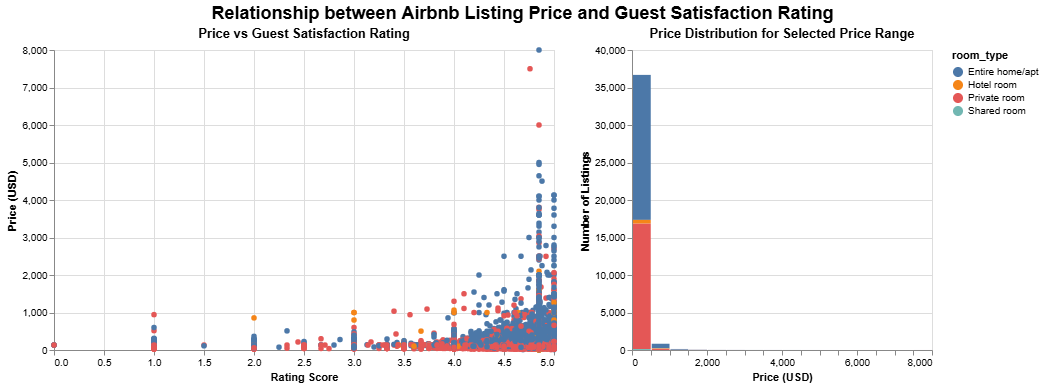

In [18]:
# Filter the data to ignore outliers 
filtered_data = df_cleaned[df_cleaned['price'] <= 8000].copy()

# Range slider for price selection
price_slider = alt.binding_range(min=0, max=8000, step=5, name="Price Range: ")
price_selection = alt.selection_interval(encodings=['y'], bind=price_slider)

# Selection for highlighting room types
highlight = alt.selection_point(fields=['room_type'], bind='legend')

# Scatterplot 
scatter_plot = alt.Chart(filtered_data).mark_circle().encode(
    alt.X('review_scores_rating:Q', title='Rating Score'),
    alt.Y('price:Q', title='Price (USD)', scale=alt.Scale(domain=[0, 8000])),
    color=alt.Color('room_type:N'), 
    opacity=alt.condition(highlight, alt.value(1), alt.value(0.2)),
    tooltip=['room_type:N', 'price:Q', 'review_scores_rating:Q']
).add_params(
    highlight,
    price_selection
).transform_filter(
    price_selection
).properties(
    width=500,
    height=300,
    title='Price vs Guest Satisfaction Rating')


# Histogram showing distribution of prices for the selected price range and room type
price_histogram = alt.Chart(filtered_data).mark_bar().encode(
    x=alt.X('price:Q', title='Price (USD)', bin=alt.Bin(maxbins=30)),
    y=alt.Y('count():Q', title='Number of Listings'),
    color=alt.Color('room_type:N'),  
    tooltip=['room_type:N', 'count():Q']
).transform_filter(
    price_selection
).add_params(
    highlight
).properties(
    width=300,
    height=300,
    title='Price Distribution for Selected Price Range')

final_chart2 = alt.hconcat(scatter_plot, price_histogram).properties(
    title={"text": "Relationship between Airbnb Listing Price and Guest Satisfaction Rating",
        "fontSize": 18,
        "fontWeight": "bold",
        "anchor": "middle"})

final_chart2

**Design Goal:**  
This visualization examines the relationship between listing prices and guest satisfaction ratings across different room types. It helps users identify trends, such as whether higher-rated listings tend to be more expensive, and provides a clearer picture of the price distribution.

**Marks:**  
Circles (Scatter Plot), Bars (Histogram)

**Channels:**  
X-Position (Rating Score), Y-Position (Price), Color Hue (Room Type), Height (Listing Count in Histogram), Opacity

**Characteristics of Channels that were exploited:**  
Position effectively maps guest ratings against price, allowing users to see trends in how price impacts satisfaction. Colour differentiates room types, while opacity highlights selected categories. In the histogram, bar height represents the number of listings at different price points.

**Describe the interaction:**  
A price range slider filters both charts, helping users focus on specific price points. The interactive legend allows users to highlight particular room types, dimming the others for better visibility. 

**Critique the view:**  
The visualization highlights how price and ratings are connected while offering flexibility through interactive filters. However, the scatter plot can become cluttered in certain price ranges, making patterns harder to distinguish. Adding density contours or a smoothing technique could help clarify overlapping points.

### Which amenities are most frequently associated with higher guest ratings in Airbnb listings?

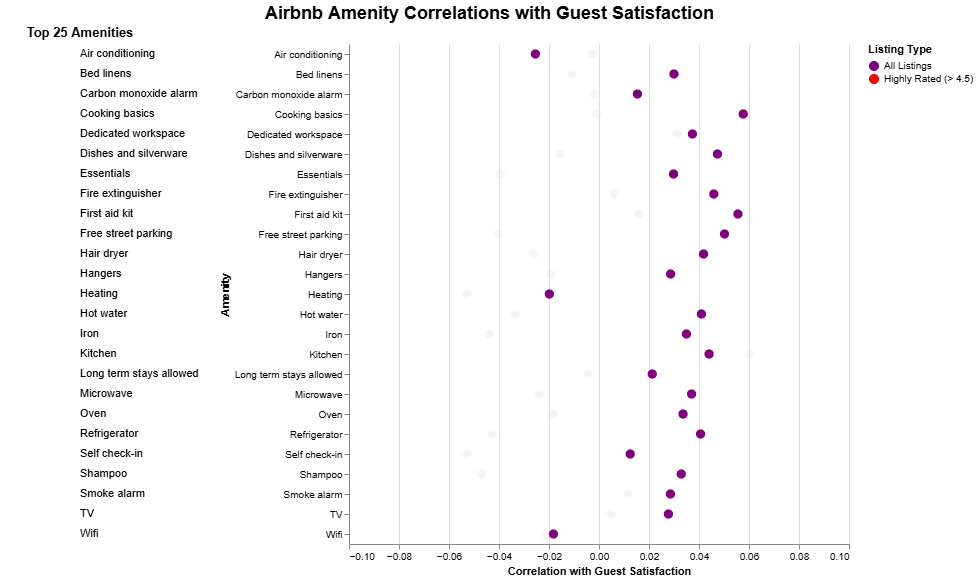

In [19]:
# List of top 25 amenities
top_25_amenities = top_25_amenities_df["Amenity"].tolist()

# Calculate correlation for all listings
correlation_all = {
    amenity: df_cleaned[amenity].corr(df_cleaned['review_scores_rating'])
    for amenity in top_25_amenities}

# Filter for highly-rated listings
df_high_rated = df_cleaned[df_cleaned['review_scores_rating'] > 4.50]

# Calculate correlation for highly-rated listings
correlation_high_rated = {
    amenity: df_high_rated[amenity].corr(df_high_rated['review_scores_rating'])
    for amenity in top_25_amenities}
correlation_df = pd.DataFrame({
    'Amenity': top_25_amenities,
    'All Listings': [correlation_all[amenity] for amenity in top_25_amenities],
    'Highly Rated (> 4.5)': [correlation_high_rated[amenity] for amenity in top_25_amenities]})

correlation_melted = correlation_df.melt(id_vars=['Amenity'], 
                                         var_name='Category', 
                                         value_name='Correlation')
# UI widgets 
radio_button = alt.binding_radio(options=["All Listings", "Highly Rated (> 4.5)"], name="Select Listing Type: ")
category_selection = alt.selection_point(fields=["Category"], bind=radio_button, value="All Listings")
amenity_selection = alt.selection_point(fields=["Amenity"], on="click", toggle="true")

# Cleveland Dot Plot
dot_plot = alt.Chart(correlation_melted).mark_circle(size=85).encode(
    x=alt.X("Correlation:Q", title="Correlation with Guest Satisfaction", scale=alt.Scale(zero=False, domain=[-0.1, 0.1])),
    y=alt.Y("Amenity:N", title="Amenity"),
    color=alt.condition(
        category_selection & amenity_selection,
        alt.Color("Category:N",
                  scale=alt.Scale(
                      domain=["All Listings", "Highly Rated (> 4.5)"],
                      range=["purple", "red"]),
                  legend=alt.Legend(title="Listing Type")),
        alt.ColorValue("lightgray")),
    opacity=alt.condition(
        category_selection & amenity_selection,
        alt.value(1),  
        alt.value(0.2)), 
    tooltip=["Amenity:N", "Correlation:Q", "Category:N"]
).add_params(category_selection, amenity_selection).properties(
    width=500,
    height=500)


# Amenity List
amenity_list = alt.Chart(correlation_df).mark_text(align="left", baseline="middle").encode(
    y=alt.Y("Amenity:N", title=None, axis=None), 
    text="Amenity:N",
    color=alt.condition(amenity_selection, alt.ColorValue("black"), alt.ColorValue("black")),
    opacity=alt.condition(amenity_selection, alt.value(1), alt.value(0.2))
).add_params(amenity_selection).properties(
    width=150,
    height=500,
    title="Top 25 Amenities")

final_chart3 = alt.hconcat(amenity_list, dot_plot).properties(
    title={"text": "Airbnb Amenity Correlations with Guest Satisfaction",
        "fontSize": 18,
        "fontWeight": "bold",
        "anchor": "middle"}).configure_view(strokeWidth=0)

final_chart3

**Design Goal:**  
This visualization explores which amenities are most frequently linked to higher guest satisfaction in Airbnb listings. It allows users to compare correlations for all listings and highly-rated listings (ratings > 4.5) to see which amenities matter most.

**Marks:**  
Circles (Dot Plot), Text (Amenity List)

**Channels:**  
X-Position (Correlation Strength), Y-Position (Amenity), Color Hue (Listing Type), Opacity

**Characteristics of Channels that were exploited:**  
The position of each dot represents the correlation strength for each amenity. Colour differentiates between all listings and highly-rated listings, while opacity helps highlight selected amenities. The interactive text list also makes it easy to choose specific amenities.

**Describe the interaction:**  
A radio button lets users switch between all listings and highly-rated listings. Clicking an amenity in the list highlights its corresponding dot in the plot, and selecting a dot in the plot also highlights the corresponding text in the list, providing bidirectional linking. 

**Critique the view:**  
The visualization effectively highlights which amenities are associated with better guest ratings. However, since correlation does not imply causation, some amenities may appear important even if they don’t directly influence guest satisfaction. Additional analysis could help clarify whether these relationships are meaningful.